In [22]:
import os
import requests
import json
import pandas as pd
import hvplot.pandas
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [23]:
load_dotenv()

True

In [24]:
# Retrieve API keys for Alpaca
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

display(alpaca_api_key)
display(alpaca_secret_key)

'PKASSM0OBO0C8IAEALKM'

'VuowGmr5I9mcIEeWsUFUfIK2uxhFCMAlHRrOGfnJ'

In [25]:
# Create REST object for Alpaca calls
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [26]:
#tickers = ["AAVEUSD", "ETHUSD"]#, "AMZN", "NFLX", "GOOG", "SPY"]
#crypto_ticker = ["BTCUSD", "AAVEUSD", "ETHUSD", "LINKUSD", "BATUSD", "GRTUSD", "MATICUSD"]
crypto_ticker = ["BTCUSD"]
crypto_timeframe = "1Day"
crypto_start_date = pd.Timestamp("2017-05-11", tz="America/New_York").isoformat()
crypto_end_date = pd.Timestamp("2022-05-11", tz="America/New_York").isoformat()

In [27]:
crypto_closing_prices = alpaca.get_crypto_bars(
    crypto_ticker,
    crypto_timeframe,
    start=crypto_start_date,
    end=crypto_end_date
).df

#btc_closing_prices = btc_closing_prices[~btc_closing_prices.index.duplicated(keep='first')]
#btc_closing_prices = btc_closing_prices[~btc_closing_prices.index.duplicated(keep='first')]

crypto_closing_prices.index = crypto_closing_prices.index.date
crypto_closing_prices.reset_index(inplace=True, drop=True)
#crypto_closing_prices.index = crypto_closing_prices.index.drop_duplicates(keep='first')
display(crypto_closing_prices.tail(10))

,exchange,open,high,low,close,volume,trade_count,vwap,symbol
2789,FTXU,35710.00,36124.00,34213.00,34401.00,1009.836900,5993,35134.932435,BTCUSD
2790,CBSE,34388.96,34938.41,33256.00,33632.87,20886.750259,597004,34194.225303,BTCUSD
2791,ERSX,34390.60,34897.20,33295.30,33657.30,61.542249,1395,34236.002941,BTCUSD
2792,FTXU,34396.00,34940.00,33267.00,33644.00,1115.738000,7073,34086.382224,BTCUSD
2793,CBSE,33639.27,33761.82,29735.05,31218.89,64818.889479,1760884,31523.597278,BTCUSD
2794,ERSX,33649.40,33688.50,29746.80,31215.00,266.883037,3175,31418.266551,BTCUSD
2795,FTXU,33678.00,33750.00,29743.00,31221.00,2605.004900,17297,31561.717220,BTCUSD
2796,CBSE,31216.25,32645.49,30152.94,31208.80,45873.673166,1333050,31425.173993,BTCUSD
2797,ERSX,31221.40,32642.20,30161.00,31219.10,218.305774,3539,31486.747210,BTCUSD
2798,FTXU,31222.00,32642.00,30164.00,31216.00,2142.923600,19848,31341.170618,BTCUSD


In [28]:
stock_ticker = ["SNDL"]#, "CLNE", "RLGY", "CDE", "PFE", "ENB"]
stock_timeframe = "1Day"
stock_start_date = pd.Timestamp("2017-05-11", tz="America/New_York").isoformat()
stock_end_date = pd.Timestamp("2022-05-11", tz="America/New_York").isoformat()

In [29]:
initial_closing_prices = alpaca.get_bars(
    stock_ticker,
    stock_timeframe,
    start=stock_start_date,
    end=stock_end_date
).df

initial_closing_prices.index = initial_closing_prices.index.date
initial_closing_prices.reset_index(inplace=True, drop=True)
initial_closing_prices

,open,high,low,close,volume,trade_count,vwap,symbol
0,13.0100,13.219900,7.6600,8.4800,9318799,40914,10.844334,SNDL
1,8.4200,10.480000,8.4200,10.4500,2693863,11109,9.537103,SNDL
2,10.6900,11.820000,10.4700,11.7000,2206717,10017,11.198821,SNDL
3,12.0000,13.210000,11.9900,13.0000,2180774,8532,12.616068,SNDL
4,13.0500,13.220000,12.2000,12.8500,1611203,7550,12.779096,SNDL
...,...,...,...,...,...,...,...,...
696,0.4900,0.494269,0.4600,0.4648,67388817,46394,0.470780,SNDL
697,0.4620,0.465000,0.4444,0.4545,64887157,44444,0.453737,SNDL
698,0.4420,0.447900,0.4050,0.4103,85332183,72867,0.420884,SNDL
699,0.4265,0.426500,0.3750,0.4000,106595625,73261,0.399077,SNDL


In [33]:
combined_df = pd.concat([crypto_closing_prices, initial_closing_prices], axis=1, keys=['BTCUSD', 'SNDL'])
combined_df = combined_df.dropna()
combined_df

BTCUSD                                                                \
    exchange     open     high      low    close        volume trade_count   
0       CBSE  1837.98  1838.00  1753.39  1756.68   2659.161185        7006   
1       CBSE  1756.57  1825.00  1653.06  1695.61  10746.820585       33243   
2       CBSE  1791.70  1814.61  1770.38  1789.73   2566.756664        7428   
3       CBSE  1790.00  1829.00  1763.33  1799.99   4078.978879       17156   
4       CBSE  1747.81  1748.99  1690.14  1722.01   3146.775082        9901   
..       ...      ...      ...      ...      ...           ...         ...   
696     CBSE  5194.76  5352.50  5170.70  5317.87   5838.659259       18113   
697     CBSE  5317.07  5317.08  5132.28  5285.54   9871.200099       45708   
698     CBSE  5187.21  5245.88  5164.49  5232.63   1837.437861       10288   
699     CBSE  5233.11  5488.00  5213.06  5318.58  14580.685736       48072   
700     CBSE  5040.11  5049.64  4901.99  5032.28   4060.436909       15648   

                             SNDL                                            \
            vwap  symbol     open       high      low    close       volume   
0    1803.508434  BTCUSD  13.0100  13.219900   7.6600   8.4800    9318799.0   
1    1745.861376  BTCUSD   8.4200  10.480000   8.4200  10.4500    2693863.0   
2    1798.657810  BTCUSD  10.6900  11.820000  10.4700  11.7000    2206717.0   
3    1797.488239  BTCUSD  12.0000  13.210000  11.9900  13.0000    2180774.0   
4    1721.033596  BTCUSD  13.0500  13.220000  12.2000  12.8500    1611203.0   
..           ...     ...      ...        ...      ...      ...          ...   
696  5280.269640  BTCUSD   0.4900   0.494269   0.4600   0.4648   67388817.0   
697  5229.695755  BTCUSD   0.4620   0.465000   0.4444   0.4545   64887157.0   
698  5217.197847  BTCUSD   0.4420   0.447900   0.4050   0.4103   85332183.0   
699  5334.433730  BTCUSD   0.4265   0.426500   0.3750   0.4000  106595625.0   
700  4979.854819  BTCUSD   0.3885   0.398400   0.3701   0.3714   80215542.0   

                                   
    trade_count       vwap symbol  
0       40914.0  10.844334   SNDL  
1       11109.0   9.537103   SNDL  
2       10017.0  11.198821   SNDL  
3        8532.0  12.616068   SNDL  
4        7550.0  12.779096   SNDL  
..          ...        ...    ...  
696     46394.0   0.470780   SNDL  
697     44444.0   0.453737   SNDL  
698     72867.0   0.420884   SNDL  
699     73261.0   0.399077   SNDL  
700     68335.0   0.380914   SNDL  

[701 rows x 17 columns]

In [40]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_five_year = MCSimulation(
    portfolio_data = combined_df,
    weights = [.50,.50],
    num_simulation = 100,
    num_trading_days = 252*20
)

# Review the simulation input data
MC_five_year.portfolio_data.head()

BTCUSD                                                                \
  exchange     open     high      low    close        volume trade_count   
0     CBSE  1837.98  1838.00  1753.39  1756.68   2659.161185        7006   
1     CBSE  1756.57  1825.00  1653.06  1695.61  10746.820585       33243   
2     CBSE  1791.70  1814.61  1770.38  1789.73   2566.756664        7428   
3     CBSE  1790.00  1829.00  1763.33  1799.99   4078.978879       17156   
4     CBSE  1747.81  1748.99  1690.14  1722.01   3146.775082        9901   

                                      SNDL                                    \
          vwap  symbol daily_return   open     high    low  close     volume   
0  1803.508434  BTCUSD          NaN  13.01  13.2199   7.66   8.48  9318799.0   
1  1745.861376  BTCUSD    -0.034764   8.42  10.4800   8.42  10.45  2693863.0   
2  1798.657810  BTCUSD     0.055508  10.69  11.8200  10.47  11.70  2206717.0   
3  1797.488239  BTCUSD     0.005733  12.00  13.2100  11.99  13.00  2180774.0   
4  1721.033596  BTCUSD    -0.043322  13.05  13.2200  12.20  12.85  1611203.0   

                                              
  trade_count       vwap symbol daily_return  
0     40914.0  10.844334   SNDL          NaN  
1     11109.0   9.537103   SNDL     0.232311  
2     10017.0  11.198821   SNDL     0.119617  
3      8532.0  12.616068   SNDL     0.111111  
4      7550.0  12.779096   SNDL    -0.011538

In [41]:
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.076597,1.068197,0.928293,1.119895,0.926968,0.961400,1.076075,0.913920,0.990645,1.050071,...,0.978757,1.004260,1.063337,0.992872,1.088687,1.107833,1.023029,0.932484,1.045856,0.957349
2,1.066741,1.002285,0.965603,1.177067,0.966053,0.920983,1.143349,0.873867,0.997484,1.105295,...,0.993615,0.906136,1.040598,1.035258,1.173782,1.166735,0.924431,0.972947,1.013140,0.858565
3,1.043598,0.970187,0.958171,1.174347,0.882198,0.874373,1.254046,0.957374,1.045177,1.089539,...,1.008925,0.983339,1.044718,0.973023,1.095436,1.146841,0.950669,1.045427,1.074129,0.701917
4,1.024356,0.970359,0.983059,1.195608,0.953126,0.868528,1.333829,0.904730,0.990518,1.220257,...,0.998022,0.989062,1.062159,0.862901,0.973034,1.155940,0.890117,1.050435,1.089168,0.732994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,0.000669,0.076814,3.435527,53.851495,0.105591,2.438505,2.427716,0.000555,0.069976,0.728052,...,0.016224,0.001766,0.059661,437.237708,0.003810,0.009745,0.012744,8.957821,46.040054,0.006584
5037,0.000696,0.082072,3.358490,51.500626,0.107326,2.657203,2.401017,0.000569,0.072290,0.734861,...,0.016102,0.001915,0.062367,416.693000,0.003734,0.010099,0.012907,9.214284,46.912290,0.006951
5038,0.000726,0.083323,3.330955,53.010375,0.111096,2.514863,2.465116,0.000590,0.079300,0.752074,...,0.016011,0.002026,0.056898,389.384197,0.003991,0.009728,0.012903,8.499983,48.170222,0.006332
5039,0.000784,0.083578,3.027205,58.050704,0.116726,2.638863,2.401724,0.000652,0.076051,0.645324,...,0.016522,0.001741,0.060566,411.555472,0.003839,0.008573,0.013305,8.060850,49.170635,0.006748


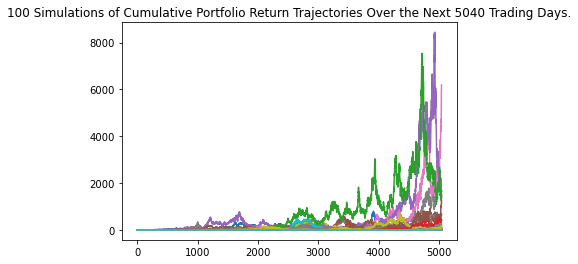

In [42]:
MC_line_plot = MC_five_year.plot_simulation()

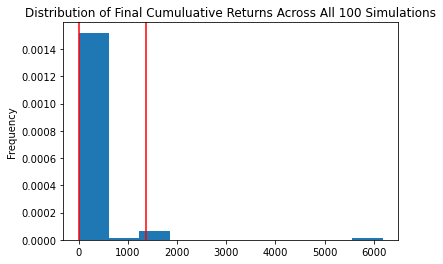

In [43]:
MC_histo_plot = MC_five_year.plot_distribution()

In [39]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_stats = MC_five_year.summarize_cumulative_return()


# Review the 30-year Monte Carlo summary statistics
display(MC_summary_stats)

count           100.000000
mean              2.447085
std               7.407303
min               0.001007
25%               0.141275
50%               0.688337
75%               2.029661
max              68.052646
95% CI Lower      0.005442
95% CI Upper     15.461410
Name: 1260, dtype: float64